In [25]:
import geopandas as gpd # to show georeferences
import matplotlib.pyplot as plt # plots
import numpy as np # manipulate data and do calculations
import pandas as pd # manipulate data
from pykrige.ok import OrdinaryKriging # to use KriGing method
import rasterio # to interpolate using images
import rasterio.mask
from rasterio.plot import show # to show the images
from rasterio.transform import Affine # to do some transformations
from scipy.spatial import Voronoi, voronoi_plot_2d # to implement voronoi diagrame
from shapely.geometry import box # to work with spatial data
from shapely.geometry import Polygon, Point # to create polygons
from sklearn.metrics import r2_score # to measure accuracy
from sklearn.model_selection import train_test_split # to split data

# Functions

In [26]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # extraemos la resolución
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # aplicamos una transformación de escala
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # exportamos el array a un raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z.shape[0],
            width = Z.shape[1],
            count = 1,
            dtype = Z.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z, 1)
            
def Random_Points_in_Bounds(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return x, y

# Load data

In [27]:
counties = gpd.read_file("sf_bay_counties.shp") # load shape files of San Francisco City (keep all the files)
rainfall = gpd.read_file("sf_bay_rainfall.shx") # load rainfall data of San Francisco City (keep all the files)
proj = "+proj=aea +lat_1=34 +lat_2=40.5 +lat_0=0 +lon_0=-120 +x_0=0 +y_0=-4000000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"
counties = counties.to_crs(proj) # change projection of counties
rainfall = rainfall.to_crs(proj) # change projection of rainfall

# Extract rainfall information

In [28]:
x_rain = rainfall["geometry"].x # extract x coordinate
y_rain = rainfall["geometry"].y # extract y coordinate

coords_rain = [list(xy) for xy in zip(x_rain, y_rain)] # create rain coordinates as a georeference

min_x_counties, min_y_counties, max_x_counties, max_y_counties = counties.total_bounds # extract counties georeferences (bounds)

value_rain = list(rainfall["VALUE"]) # extract "value" of rainfall (average rain per year)

In [29]:
counties_dissolved = counties.copy() # create a copy
counties_dissolved["constant"] = 1 # to unify all polygons as one single  shape
counties_dissolved = counties_dissolved.dissolve(by = "constant").reset_index(drop = True) # unify polygons

# Data segmentation

In [30]:
coords_rain_train, coords_rain_test, value_rain_train, value_rain_test = train_test_split(coords_rain, value_rain, test_size = 0.20, random_state = 42) # split data, train an test

rain_train_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_rain_train], crs = proj) # load data as georeferences (train)
rain_train_gdf["Actual_Value"] = value_rain_train # add rain values (train)
rain_test_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_rain_test], crs = proj)  # load data as georeferences (test)
rain_test_gdf["Actual_Value"] = value_rain_test # add rain values (test)

min_x_rain, min_y_rain, max_x_rain, max_y_rain = rain_train_gdf.total_bounds # define max coordinates in both axis (X and Y)

# Data exploration

Text(0.5, 1.0, 'San Francisco Bay Area - Rainfall Measurement Locations')

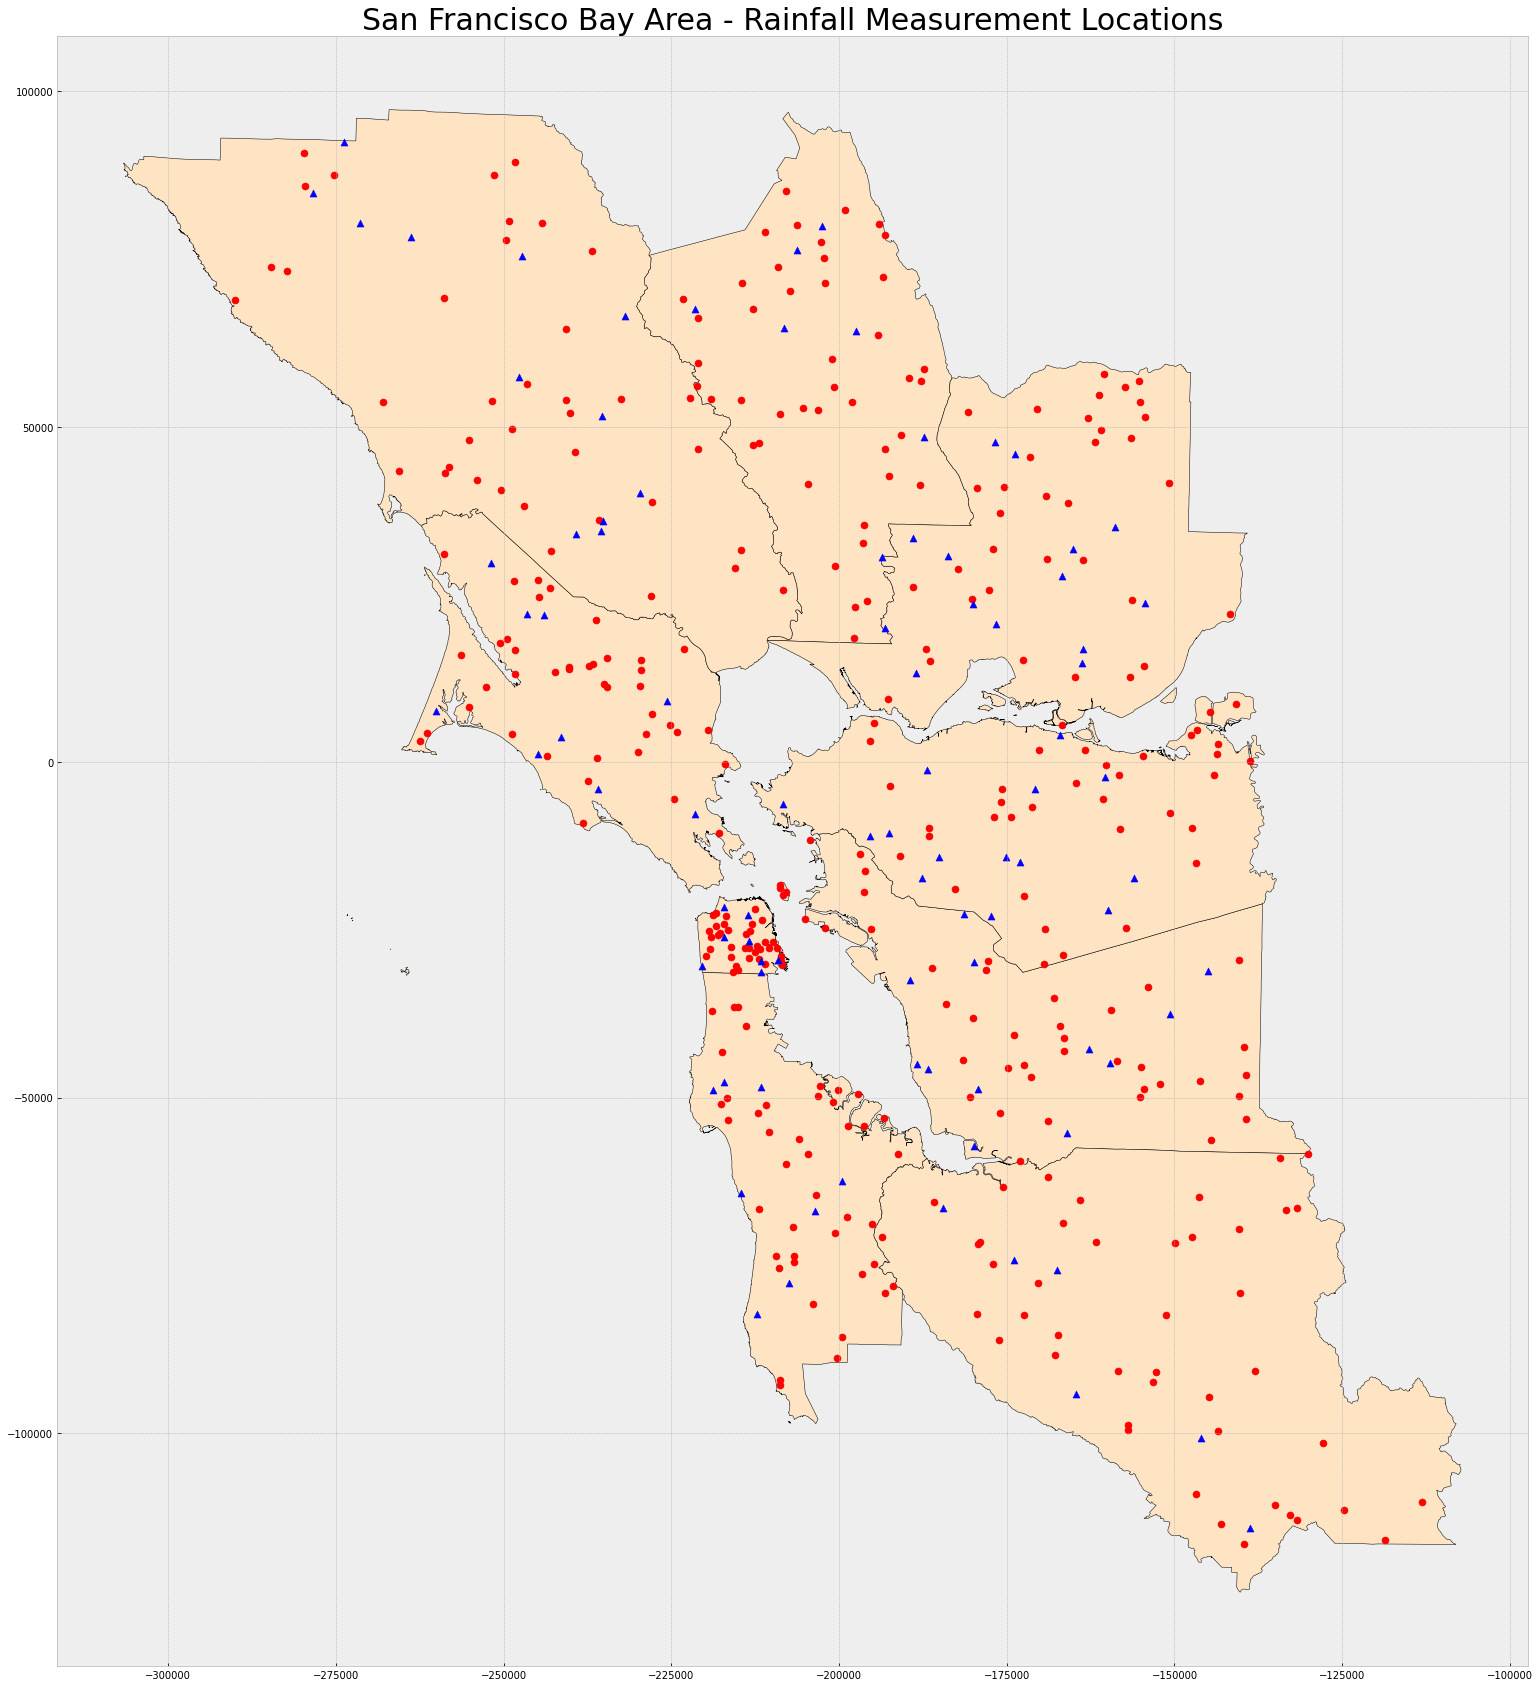

In [31]:
fig, ax = plt.subplots(1, 1, figsize = (30, 30)) # create subplot

counties.plot(ax = ax, color = 'bisque', edgecolor = 'black') # plot counties (you can change edge and fill color)
rain_train_gdf.plot(ax = ax, marker = 'o', color = 'red', markersize = 50) # plot train data (red dots)
rain_test_gdf.plot(ax = ax, marker = "^", color = 'blue', markersize = 50) # plot test data (blue triangles)
ax.set_title('San Francisco Bay Area - Rainfall Measurement Locations', fontdict = {'fontsize': '30', 'fontweight' : '3'}) # set title

# 1) Interpolation using Voronoi Method

In [32]:
counties_buffer = counties.buffer(100000)# buffer is used to measure the distance between shape objects, polygons in this case
# it shows as an edge, if the number is bigger the edge is bigger

min_x_cty_tp, min_y_cty_tp, max_x_cty_tp, max_y_cty_tp = counties_buffer.total_bounds # extract min and max coordinates of buffer

coords_tp = coords_rain_train + [[min_x_cty_tp, min_y_cty_tp], [max_x_cty_tp, min_y_cty_tp], # put coordinates into the array
                                 [max_x_cty_tp, max_y_cty_tp], [min_x_cty_tp, max_y_cty_tp]]

tp = Voronoi(coords_tp) # create voronoi polygons

tp_poly_list = []# list for polygons

for region in tp.regions: # iterate over regions

    # ignore regions -1
    if -1 in region: 
        continue
    else: 
        pass
    # if region contains info then
    if len(region) != 0: 

        # create a polygon using vertices info
        tp_poly_region = Polygon(list(tp.vertices[region]))

        # add to polygons lsit
        tp_poly_list.append(tp_poly_region)

    # if there is no values then continue
    else:
        continue

# with the generated polygons create a new geopandas 
tp_polys = gpd.GeoDataFrame(tp_poly_list, columns = ['geometry'], crs = proj)

# limit polygons with original SF map
tp_polys_clipped = gpd.clip(tp_polys, counties_dissolved)

# Asign values to Vornoi Diagram polygons

In [33]:
# assaign rainfall value to each polygon
# sjoin (spatial_join, it works similar to a merge but it considers spatial data)
# data joined are rainfallvalue related to each polygon
tp_polys_clipped_values = gpd.sjoin(rain_train_gdf, tp_polys_clipped, how = "right", predicate = 'within').drop("index_left", axis = 1).rename(columns = {"Actual_Value": "VALUE_Voronoi"})

In [34]:
# if test georeferences are within a voronoi polygon then it gets that rainfall value
rain_test_pred_tp = gpd.sjoin(rain_test_gdf, tp_polys_clipped_values, how = "left", predicate = 'within').drop("index_right", axis = 1).rename(columns = {"Actual_Value": "VALUE_Actual", "VALUE_Voronoi": "VALUE_Predict"})

# calculate correlation coef
out_r_squared_tp = r2_score(rain_test_pred_tp.VALUE_Actual, rain_test_pred_tp.VALUE_Predict)
print("Voronoi diagram out-of-sample r-squared: {}".format(round(out_r_squared_tp, 2)))

Voronoi diagram out-of-sample r-squared: 0.89


# Interpolation using Voronoi Diagram

In [35]:
x,y = Random_Points_in_Bounds(counties_dissolved["geometry"][0], 100) # generate 100 random points over the map

In [36]:
df_predicts = pd.DataFrame({"puntos_predict": list(zip(x,y))}) # save points as a list
df_predicts["puntos_predict"] = df_predicts["puntos_predict"].apply(Point)# set coordinates to those points

In [37]:
gdf_predicts = gpd.GeoDataFrame(df_predicts, geometry = "puntos_predict", crs = proj)# add them to a geopandas frame with crs from the original value

In [38]:
predict_sjoin = gpd.tools.sjoin(gdf_predicts, tp_polys_clipped_values, predicate="within", how='right').dropna(axis = 0) # just consider points that have an intersection with voronoi diagrams

In [39]:
print("Total intersection points: ", len(predict_sjoin)) #

Total intersection points:  39


In [40]:
gdf_predicts = gdf_predicts.reset_index()# reset index to perform merge

In [41]:
resultados_predicion = gdf_predicts.merge(predict_sjoin, left_on = "index", right_on = "index_left", how = "inner")# merge data

Text(0.5, 1.0, 'San Francisco Bay Area - Rainfall Predictions')

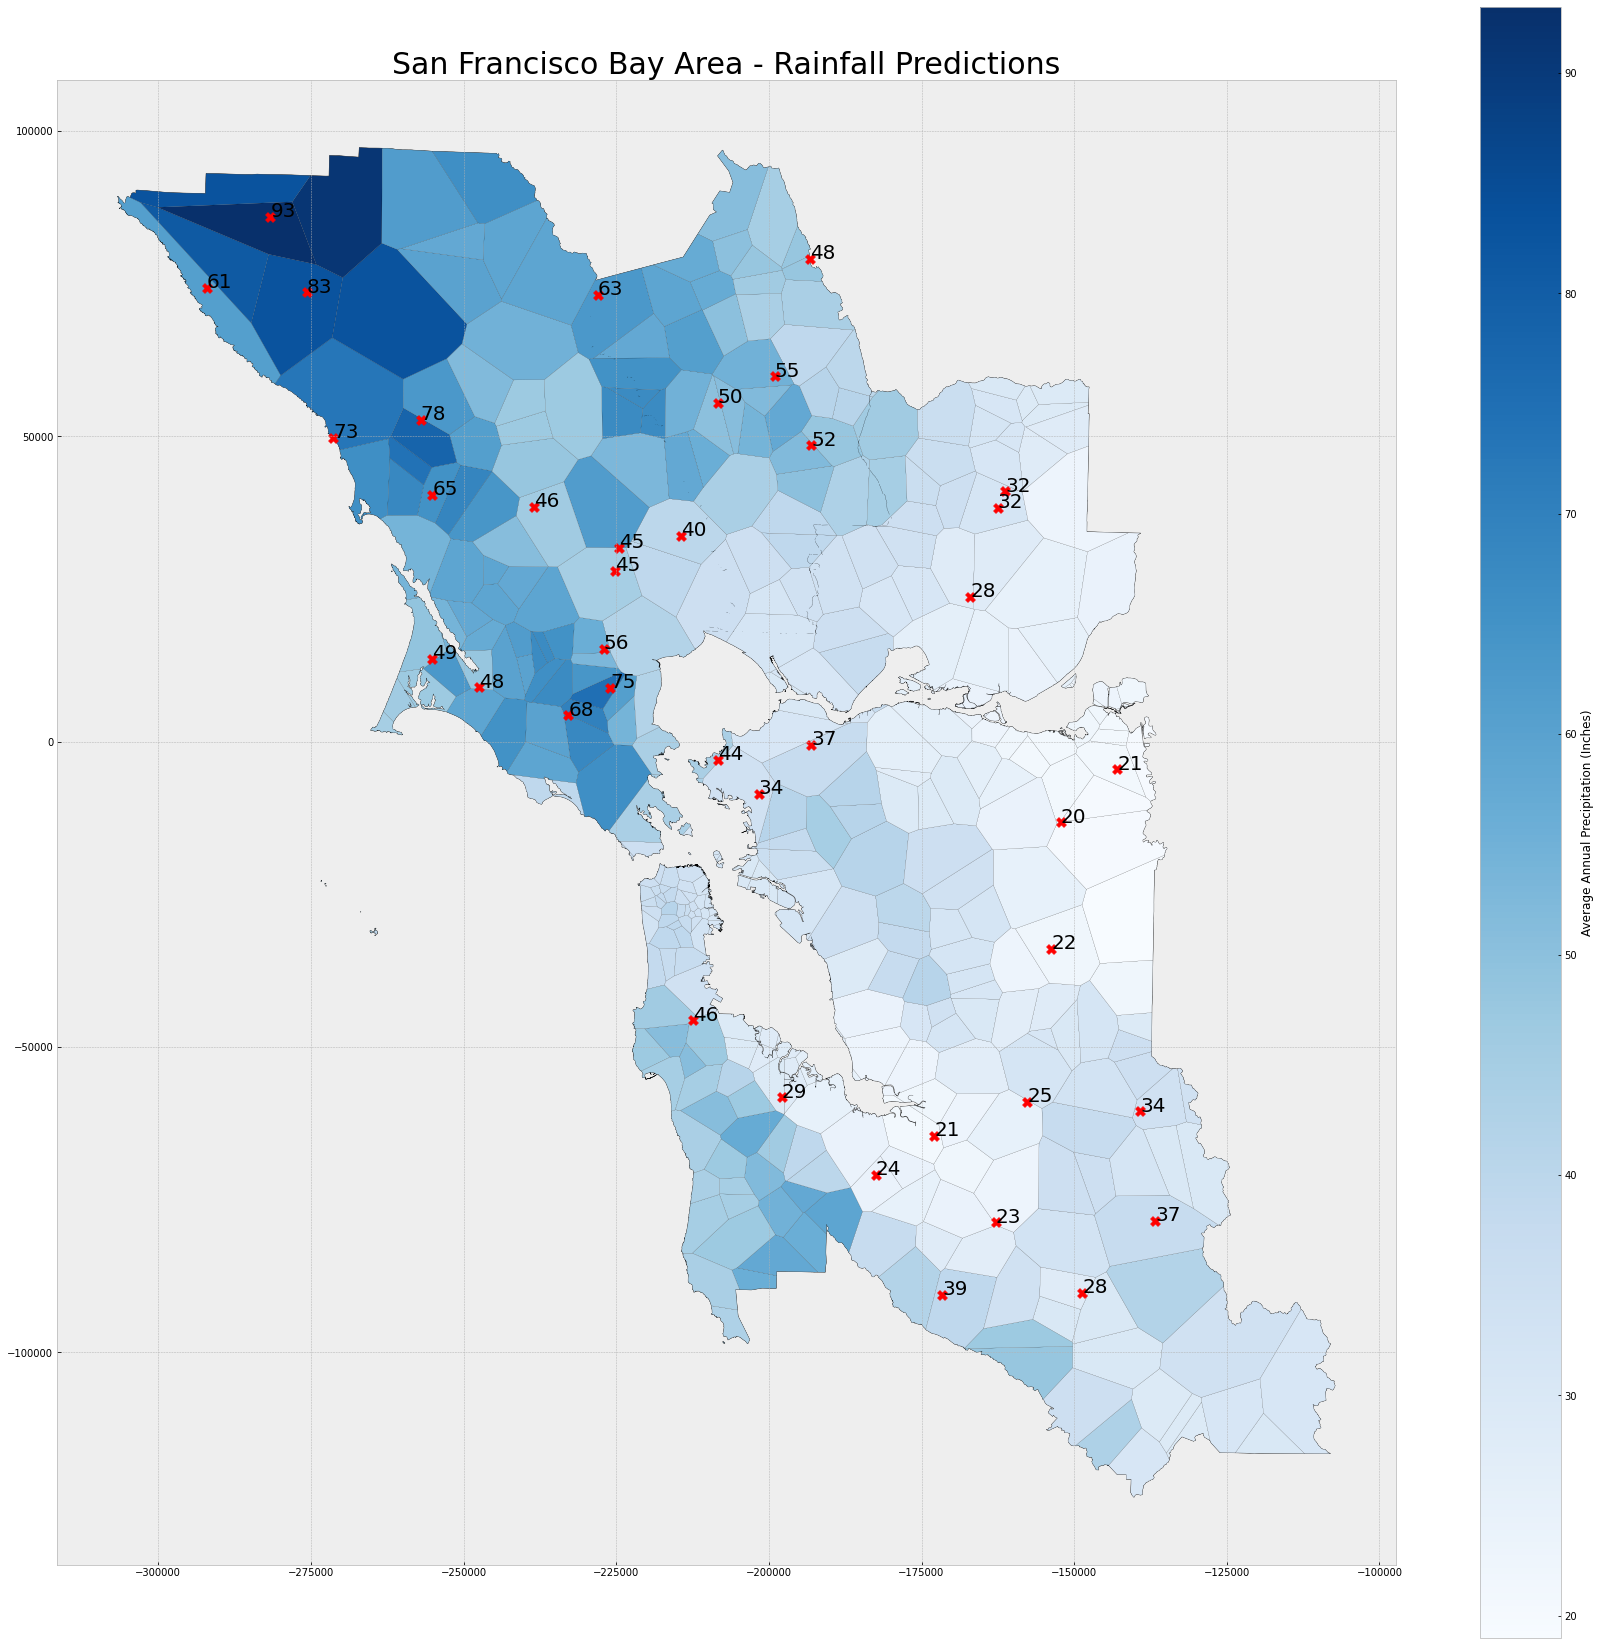

In [42]:
# Create a subplot
fig, ax = plt.subplots(1, 1, figsize = (30, 30))

counties_dissolved.plot(ax = ax, color = 'none', edgecolor = 'black') # graph counties with no fill color
tp_polys_clipped_values.plot(column = "VALUE_Voronoi", ax = ax, edgecolor = 'black', linewidth = 0.10, 
                             legend = True, cmap = "Blues", 
                             legend_kwds = {"label": "Average Annual Precipitation (Inches)"})# graph voronoi diagram
resultados_predicion.plot(ax = ax, marker = 'X', color = 'red', markersize = 100) # plot predicting points
for index, row in resultados_predicion.iterrows(): # annotate predicting points values
    plt.annotate(row.VALUE_Voronoi, (row.puntos_predict.x, row.puntos_predict.y), color = "black", fontsize = 20)

# Set title
ax.set_title('San Francisco Bay Area - Rainfall Predictions', fontdict = {'fontsize': '30', 'fontweight' : '3'})

# 2) Interpolation using KriGing Method

In [43]:
XX_pk_krig = np.linspace(min_x_rain, max_x_rain, 512)
YY_pk_krig = np.linspace(min_y_rain, max_y_rain, 512)

In [44]:
OK = OrdinaryKriging(
    np.array(x_rain),
    np.array(y_rain),
    value_rain,
    variogram_model = "linear",
    verbose = False,
    enable_plotting = False,
    coordinates_type = "euclidean",
)

OK

PyKrige Kriging out-of-sample r-squared: 0.99961118

Attribute Table: Random Points Interpolated Values - PyKrige Kriging Method


,geometry,Actual_Value,VALUE_Predict
0,POINT (-229633.109 40063.957),56,56.261048
2,POINT (-244810.053 1296.591),62,62.154295


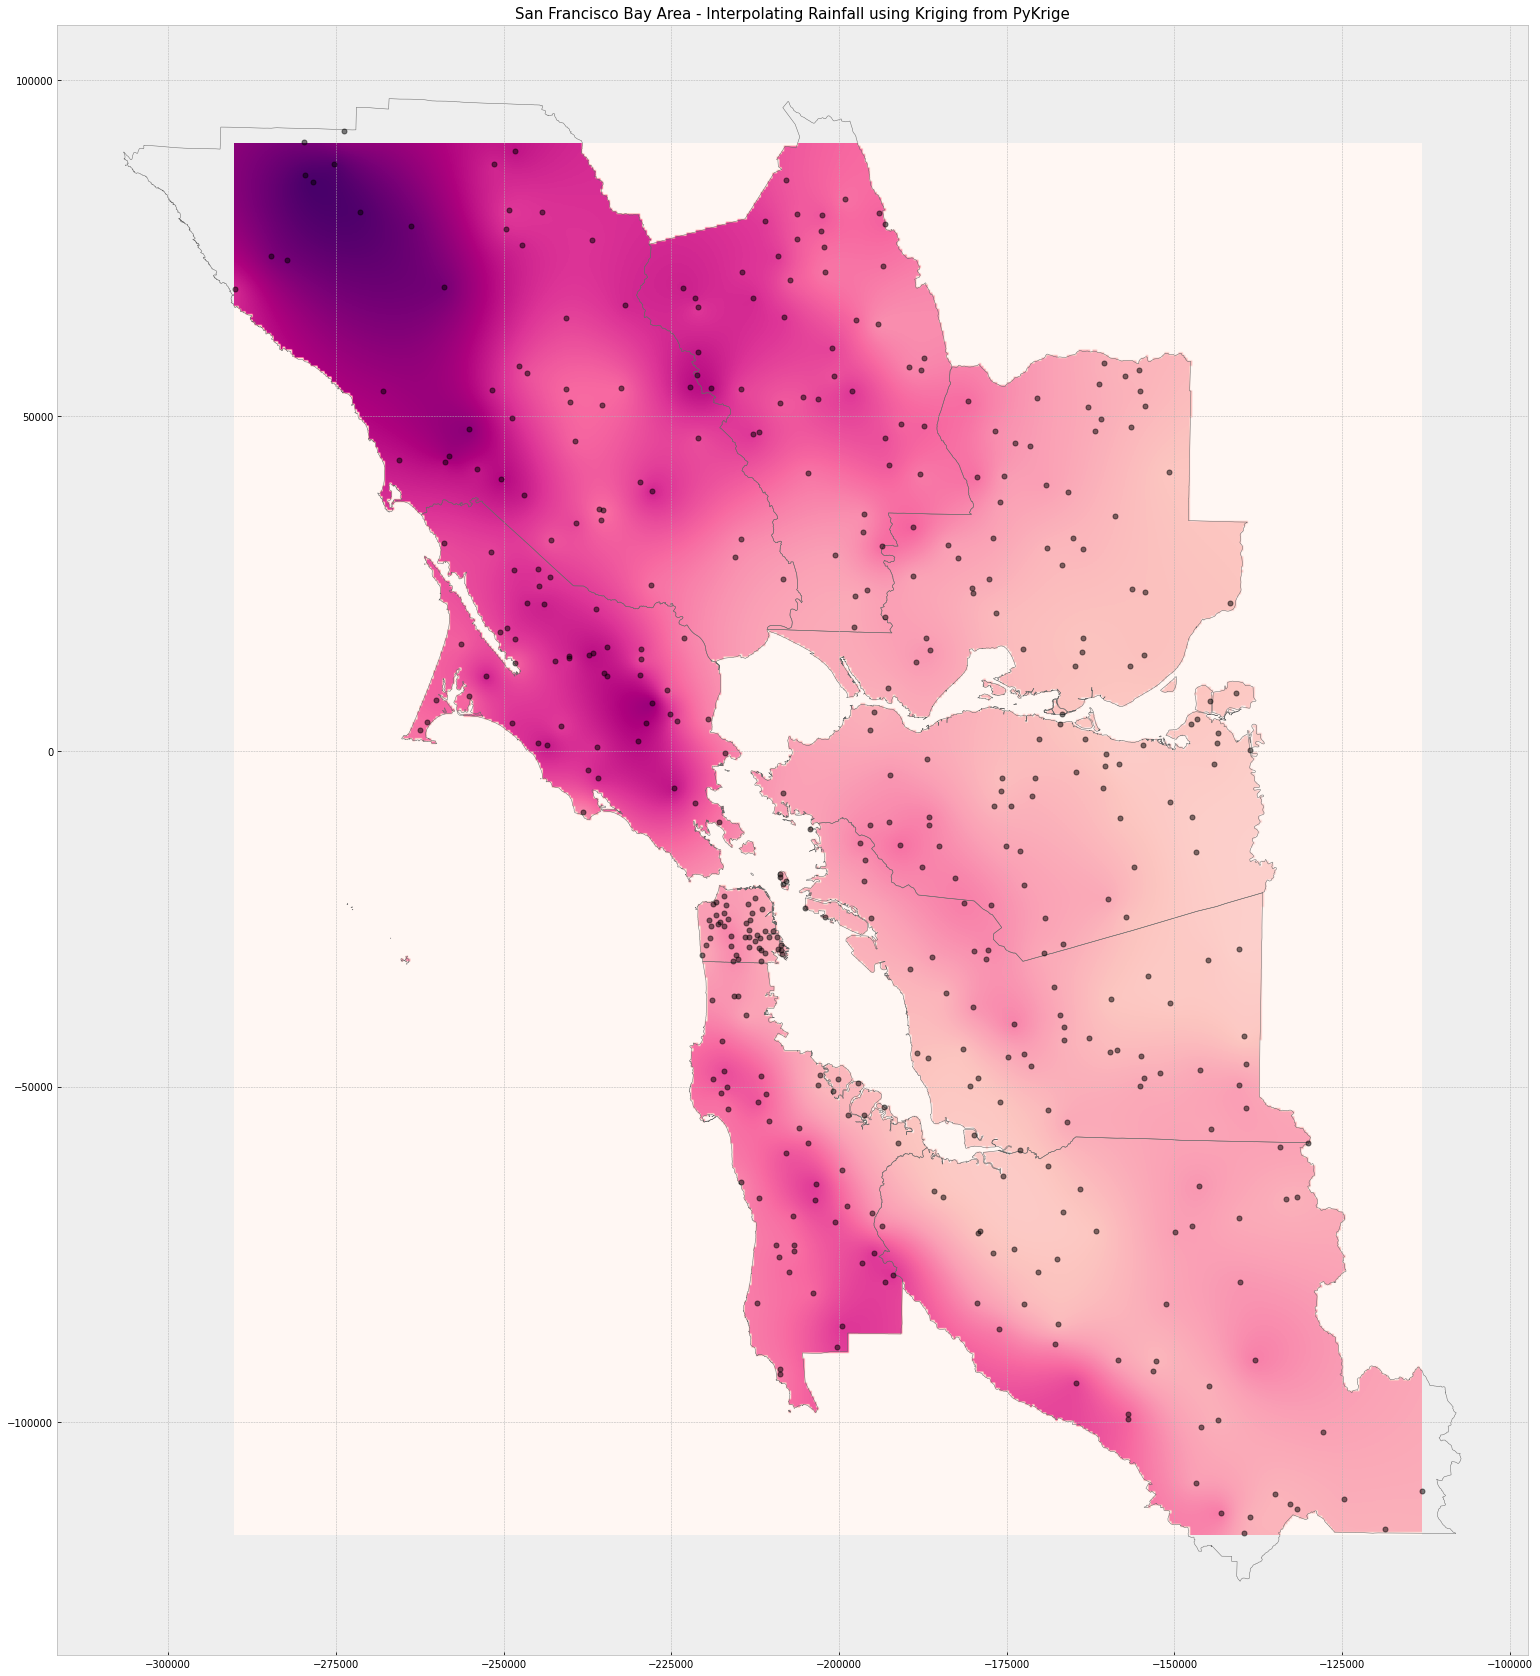

In [45]:


# Create a 512 by 512 grid
# Horizontal and vertical cell counts should be the same
XX_pk_krig = np.linspace(min_x_rain, max_x_rain, 512)
YY_pk_krig = np.linspace(min_y_rain, max_y_rain, 512)

# Generate ordinary kriging object
OK = OrdinaryKriging(
    np.array(x_rain),
    np.array(y_rain),
    value_rain,
    variogram_model = "linear",
    verbose = False,
    enable_plotting = False,
    coordinates_type = "euclidean",
)

# Evaluate the method on grid
Z_pk_krig, sigma_squared_p_krig = OK.execute("grid", XX_pk_krig, YY_pk_krig)

# Export raster
export_kde_raster(Z = Z_pk_krig, XX = XX_pk_krig, YY = YY_pk_krig,
                  min_x = min_x_rain, max_x = max_x_rain, min_y = min_y_rain, max_y = max_y_rain,
                  proj = proj, filename = "e_bay-area-rain_pk_kriging.tif")

# Open raster
raster_pk = rasterio.open("e_bay-area-rain_pk_kriging.tif")


# Create polygon with extent of raster
poly_shapely = box(*raster_pk.bounds)

# Create a dictionary with needed attributes and required geometry column
attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}

# Convert shapely object to a GeoDataFrame
raster_pk_extent = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = proj)

# Create copy of test dataset
rain_test_gdf_pk_krig = rain_test_gdf.copy()

# Subset the GeoDataFrame by checking which test points are within the raster extent polygon
# If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
rain_test_gdf_pk_krig = rain_test_gdf_pk_krig[rain_test_gdf_pk_krig.within(raster_pk_extent.geometry.values[0])]

# Create list of XY coordinate pairs for the test points that fall within raster extent polygon
coords_rain_test_pk_krig = [list(xy) for xy in zip(rain_test_gdf_pk_krig["geometry"].x, rain_test_gdf_pk_krig["geometry"].y)]

# Extract raster value at each test point and add the values to the GeoDataFrame
rain_test_gdf_pk_krig["VALUE_Predict"] = [x[0] for x in raster_pk.sample(coords_rain_test_pk_krig)]

# Generate out-of-sample R^2
out_r_squared_tp = r2_score(rain_test_gdf_pk_krig.Actual_Value, rain_test_gdf_pk_krig.VALUE_Predict)
print("PyKrige Kriging out-of-sample r-squared: {}".format(round(out_r_squared_tp, 8)))

# Display attribute table
print("\nAttribute Table: Random Points Interpolated Values - PyKrige Kriging Method")
display(rain_test_gdf_pk_krig.head(2))


# Mask raster to counties shape
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, counties.geometry.values, crop = True)
raster_pk.close()

# Stylize plots
plt.style.use('bmh')

# Plot data
fig, ax = plt.subplots(1, figsize = (30, 30))
show(out_image_pk, ax = ax, transform = out_transform_pk, cmap = "RdPu")
ax.plot(x_rain, y_rain, 'k.', markersize = 10, alpha = 0.5)
counties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
plt.gca().invert_yaxis()

# Set title
ax.set_title('San Francisco Bay Area - Interpolating Rainfall using Kriging from PyKrige', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Display plot
plt.show()